In [3]:
import kagglehub

In [6]:
# Download latest version
path = kagglehub.dataset_download("steubk/wikiart")

print("Path to dataset files:", path)

100%|██████████| 31.4G/31.4G [26:24<00:00, 21.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1


In [5]:
# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

100%|██████████| 25.0G/25.0G [19:24<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2


In [9]:
import os
import glob
import shutil

coco_train_dir = "/root/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017"
wikiart_dir = "/root/.cache/kagglehub/datasets/steubk/wikiart/versions/1"

# Собираем все файлы (recursive=True, если нужно заходить в подпапки)
coco_images = glob.glob(os.path.join(coco_train_dir, "**", "*.jpg"), recursive=True)
wikiart_images = glob.glob(os.path.join(wikiart_dir, "**", "*.jpg"), recursive=True)

print("COCO images:", len(coco_images))
print("WikiArt images:", len(wikiart_images))

# Создаём папки для выборки
os.makedirs("data/content", exist_ok=True)
os.makedirs("data/style", exist_ok=True)

# Берём первые 10k (или случайные 10k) из COCO
# Для случайного выбора можно использовать random.sample
import random
random.shuffle(coco_images)
random.shuffle(wikiart_images)

coco_subset = coco_images[:80000]
wikiart_subset = wikiart_images[:80000]

for img_path in coco_subset:
    shutil.copy(img_path, "data/content/")
for img_path in wikiart_subset:
    shutil.copy(img_path, "data/style/")

print("Copied subset to data/content and data/style.")


COCO images: 118287
WikiArt images: 81444
Copied subset to data/content and data/style.


In [10]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class SimpleImageFolder(Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        self.root = root
        self.transform = transform
        self.files = [f for f in os.listdir(root)
                      if f.lower().endswith(('.jpg','.jpeg','.png'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.root, self.files[idx])
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((256,256)),  # Можете увеличить/уменьшить
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

content_dataset = SimpleImageFolder("data/content", transform=transform)
style_dataset   = SimpleImageFolder("data/style", transform=transform)

content_loader = DataLoader(content_dataset, batch_size=32, shuffle=True, drop_last=True)
style_loader   = DataLoader(style_dataset,   batch_size=32, shuffle=True, drop_last=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Content samples:", len(content_dataset))
print("Style samples:", len(style_dataset))
print("Using device:", device)


Content samples: 80000
Style samples: 78701
Using device: cuda


In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

# 1) Функция для вычисления среднего и std
def calc_mean_std(feat, eps=1e-5):
    N, C = feat.shape[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

# 2) AdaIN
def adain(content_feat, style_feat, eps=1e-5):
    c_mean, c_std = calc_mean_std(content_feat, eps)
    s_mean, s_std = calc_mean_std(style_feat, eps)
    normalized = (content_feat - c_mean) / c_std
    return normalized * s_std + s_mean

class VGGEncoder(nn.Module):
    """
    Извлекает фичи из первых слоёв VGG19.
    """
    def __init__(self):
        super(VGGEncoder, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.slice1 = nn.Sequential(*[vgg[i] for i in range(0, 2)])  # relu1_1
        self.slice2 = nn.Sequential(*[vgg[i] for i in range(2, 7)])  # relu2_1
        self.slice3 = nn.Sequential(*[vgg[i] for i in range(7, 12)]) # relu3_1
        self.slice4 = nn.Sequential(*[vgg[i] for i in range(12, 21)])# relu4_1
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.slice1(x)
        x = self.slice2(x)
        x = self.slice3(x)
        x = self.slice4(x)
        return x

class Decoder(nn.Module):
    """
    Примерный декодер (зеркало части VGG).
    """
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.decode(x)

# Лоссы
def calc_content_loss(out_feat, target_feat):
    return F.mse_loss(out_feat, target_feat)

def calc_style_loss(out_feat, style_feat):
    out_mean, out_std = calc_mean_std(out_feat)
    style_mean, style_std = calc_mean_std(style_feat)
    return F.mse_loss(out_mean, style_mean) + F.mse_loss(out_std, style_std)


In [12]:
def train_decoder_multiepoch(encoder, decoder, content_loader, style_loader,
                             epochs=8, style_weight=10.0, lr=1e-4):
    """
    encoder: VGGEncoder (заморожен)
    decoder: Decoder (будем обучать)
    content_loader, style_loader: DataLoader'ы
    epochs: кол-во эпох
    style_weight: коэффициент для стиля
    lr: learning rate
    """

    import torch.optim as optim
    import torch.nn.functional as F
    from tqdm import tqdm

    encoder.eval()
    for param in encoder.parameters():
        param.requires_grad = False

    optimizer = optim.Adam(decoder.parameters(), lr=lr)
    decoder.train()

    best_loss = float('inf')
    history = {
        'epoch': [],
        'content_loss': [],
        'style_loss': [],
        'total_loss': []
    }

    for e in range(1, epochs+1):
        epoch_content_loss = 0.0
        epoch_style_loss = 0.0
        epoch_total_loss = 0.0
        count_batches = 0

        # Создаём итераторы по даталоадерам
        content_iter = iter(content_loader)
        style_iter   = iter(style_loader)

        # Определяем, сколько итераций будет в одной эпохе:
        steps_per_epoch = min(len(content_loader), len(style_loader))

        # Оборачиваем цикл в tqdm
        progress_bar = tqdm(range(steps_per_epoch), desc=f"Epoch [{e}/{epochs}]", leave=True)

        for _ in progress_bar:
            try:
                content_imgs = next(content_iter)
                style_imgs   = next(style_iter)
            except StopIteration:
                # Если один даталоадер закончился — прерываем эпоху
                break

            content_imgs = content_imgs.to(device)
            style_imgs   = style_imgs.to(device)

            with torch.no_grad():
                content_feat = encoder(content_imgs)
                style_feat   = encoder(style_imgs)

            t = adain(content_feat, style_feat)
            out = decoder(t)

            out_feat = encoder(out)

            loss_c = calc_content_loss(out_feat, t)
            loss_s = calc_style_loss(out_feat, style_feat)
            loss   = loss_c + style_weight * loss_s

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_content_loss += loss_c.item()
            epoch_style_loss   += loss_s.item()
            epoch_total_loss   += loss.item()
            count_batches += 1

            progress_bar.set_postfix({
                'c_loss': f"{loss_c.item():.3f}",
                's_loss': f"{loss_s.item():.3f}",
                'total': f"{loss.item():.3f}"
            })

        if count_batches > 0:
            epoch_content_loss /= count_batches
            epoch_style_loss   /= count_batches
            epoch_total_loss   /= count_batches

        print(f"\nEpoch [{e}/{epochs}] "
              f"Content Loss: {epoch_content_loss:.4f}, "
              f"Style Loss: {epoch_style_loss:.4f}, "
              f"Total Loss: {epoch_total_loss:.4f}")

        history['epoch'].append(e)
        history['content_loss'].append(epoch_content_loss)
        history['style_loss'].append(epoch_style_loss)
        history['total_loss'].append(epoch_total_loss)

        # Сохраняем "лучшие" веса
        if epoch_total_loss < best_loss:
            best_loss = epoch_total_loss
            torch.save(decoder.state_dict(), "best_decoder.pth")
            print("  -> Best model saved with total loss =", best_loss)

    return history


In [14]:
%%time
encoder = VGGEncoder().to(device).eval()
decoder = Decoder().to(device)

history = train_decoder_multiepoch(
    encoder, decoder,
    content_loader, style_loader,
    epochs=5,
    style_weight=10,
    lr=1e-4
)


Epoch [1/5]: 100%|██████████| 2459/2459 [56:52<00:00,  1.39s/it, c_loss=10.861, s_loss=0.992, total=20.776]



Epoch [1/5] Content Loss: 12.4339, Style Loss: 1.3824, Total Loss: 26.2583
  -> Best model saved with total loss = 26.25825620793191


Epoch [2/5]: 100%|██████████| 2459/2459 [54:08<00:00,  1.32s/it, c_loss=7.869, s_loss=0.668, total=14.545]



Epoch [2/5] Content Loss: 9.3747, Style Loss: 0.8636, Total Loss: 18.0103
  -> Best model saved with total loss = 18.010273660766057


Epoch [3/5]: 100%|██████████| 2459/2459 [52:47<00:00,  1.29s/it, c_loss=8.543, s_loss=0.749, total=16.038]



Epoch [3/5] Content Loss: 8.4938, Style Loss: 0.7739, Total Loss: 16.2324
  -> Best model saved with total loss = 16.232359396339966


Epoch [4/5]: 100%|██████████| 2459/2459 [52:48<00:00,  1.29s/it, c_loss=7.027, s_loss=0.596, total=12.983]



Epoch [4/5] Content Loss: 8.0254, Style Loss: 0.7231, Total Loss: 15.2562
  -> Best model saved with total loss = 15.256209086091987


Epoch [5/5]: 100%|██████████| 2459/2459 [52:59<00:00,  1.29s/it, c_loss=8.853, s_loss=0.813, total=16.980]


Epoch [5/5] Content Loss: 7.7087, Style Loss: 0.6881, Total Loss: 14.5893
  -> Best model saved with total loss = 14.589258104768794
CPU times: user 10h 21min 47s, sys: 2min 41s, total: 10h 24min 28s
Wall time: 4h 29min 38s


In [31]:
%%time
encoder = VGGEncoder().to(device).eval()
decoder = Decoder().to(device)

history = train_decoder_multiepoch(
    encoder, decoder,
    content_loader, style_loader,
    epochs=8,
    style_weight=10,
    lr=1e-4
)


Epoch [1/8]: 100%|██████████| 650/650 [07:06<00:00,  1.53it/s, c_loss=14.874, s_loss=1.536, total=30.233]



Epoch [1/8] Content Loss: 16.4133, Style Loss: 2.4732, Total Loss: 41.1451
  -> Best model saved with total loss = 41.145115476754995


Epoch [2/8]: 100%|██████████| 650/650 [07:05<00:00,  1.53it/s, c_loss=13.245, s_loss=1.269, total=25.930]



Epoch [2/8] Content Loss: 13.7032, Style Loss: 1.3362, Total Loss: 27.0656
  -> Best model saved with total loss = 27.06561004638672


Epoch [3/8]: 100%|██████████| 650/650 [07:07<00:00,  1.52it/s, c_loss=11.319, s_loss=0.930, total=20.623]



Epoch [3/8] Content Loss: 12.1414, Style Loss: 1.1445, Total Loss: 23.5862
  -> Best model saved with total loss = 23.586176581749548


Epoch [4/8]: 100%|██████████| 650/650 [07:08<00:00,  1.52it/s, c_loss=9.228, s_loss=0.849, total=17.713]



Epoch [4/8] Content Loss: 11.1875, Style Loss: 1.0453, Total Loss: 21.6408
  -> Best model saved with total loss = 21.640760838435245


Epoch [5/8]: 100%|██████████| 650/650 [07:13<00:00,  1.50it/s, c_loss=10.760, s_loss=0.987, total=20.633]



Epoch [5/8] Content Loss: 10.5604, Style Loss: 0.9818, Total Loss: 20.3784
  -> Best model saved with total loss = 20.378389741457426


Epoch [6/8]: 100%|██████████| 650/650 [07:13<00:00,  1.50it/s, c_loss=8.467, s_loss=0.707, total=15.532]



Epoch [6/8] Content Loss: 10.1178, Style Loss: 0.9418, Total Loss: 19.5355
  -> Best model saved with total loss = 19.535524749755858


Epoch [7/8]: 100%|██████████| 650/650 [07:06<00:00,  1.52it/s, c_loss=10.154, s_loss=0.899, total=19.146]



Epoch [7/8] Content Loss: 9.7366, Style Loss: 0.9006, Total Loss: 18.7426
  -> Best model saved with total loss = 18.742564346606915


Epoch [8/8]: 100%|██████████| 650/650 [07:05<00:00,  1.53it/s, c_loss=10.160, s_loss=1.099, total=21.152]


Epoch [8/8] Content Loss: 9.4663, Style Loss: 0.8770, Total Loss: 18.2367
  -> Best model saved with total loss = 18.236661887535682
CPU times: user 2h 12min 28s, sys: 37.7 s, total: 2h 13min 5s
Wall time: 57min 8s


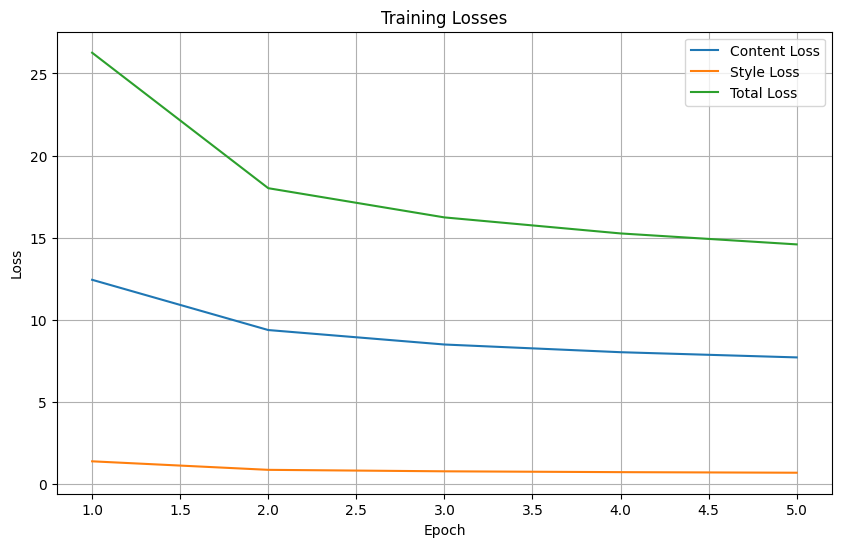

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history['epoch'], history['content_loss'], label='Content Loss')
plt.plot(history['epoch'], history['style_loss'], label='Style Loss')
plt.plot(history['epoch'], history['total_loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
best_decoder = Decoder().to(device)
best_decoder.load_state_dict(torch.load("best_decoder.pth", map_location=device))
best_decoder.eval()


<ipython-input-16-dfbe7640b885>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_decoder.load_state_dict(torch.load("best_decoder.pth", map_location=device))


Decoder(
  (decode): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Upsample(scale_factor=2.0, mode='nearest')
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Upsample(scale_factor=2.0, mode='nearest')
    (17): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [17]:
class StyleTransferNet(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, content, style, alpha=1.0):
        # 1) Извлекаем фичи
        content_feat = self.encoder(content)
        style_feat   = self.encoder(style)
        # 2) AdaIN
        t = adain(content_feat, style_feat)
        # 3) Смешиваем с контентом
        t = alpha * t + (1 - alpha) * content_feat
        # 4) Декодируем
        out = self.decoder(t)
        return out


In [18]:
encoder = VGGEncoder().to(device).eval()
net = StyleTransferNet(encoder, best_decoder).to(device)
net.eval()


StyleTransferNet(
  (encoder): VGGEncoder(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (slice4): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv

In [19]:
from PIL import Image
import torchvision.transforms as transforms

infer_transform = transforms.Compose([
    transforms.Resize((256,256)),  =
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = infer_transform(img).unsqueeze(0)  # => shape (1,3,H,W)
    return img.to(device)


In [23]:
content_img = load_image("hugh_jackman.jpg")
style_img   = load_image("picasso.jpeg")


In [ ]:
content_img = load_image("hugh_jackman.jpg")
style_img   = load_image("picasso.jpeg")


In [24]:
with torch.no_grad():
    output = net(content_img, style_img, alpha=1.0)


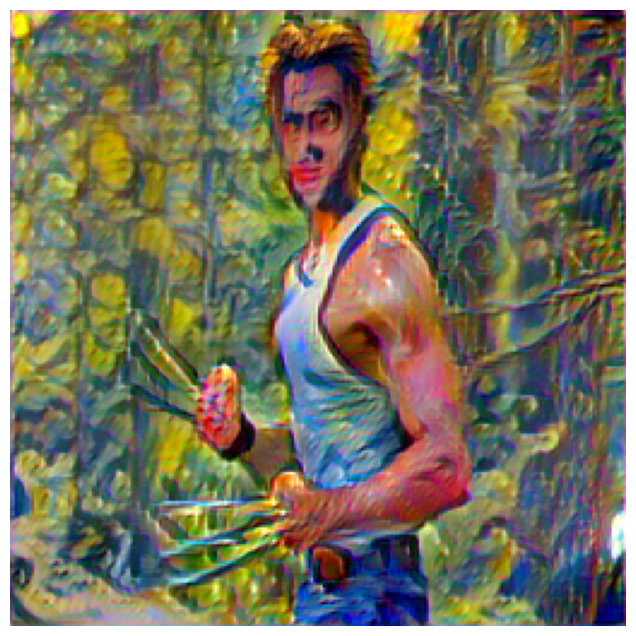

In [22]:
import torch
#80K pics in training set
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(tensor.device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(tensor.device)
    return tensor * std + mean

out_img = denormalize(output).clamp(0,1)

import torchvision.utils as vutils
vutils.save_image(out_img, "stylized_result.jpg")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(out_img.squeeze(0).permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()


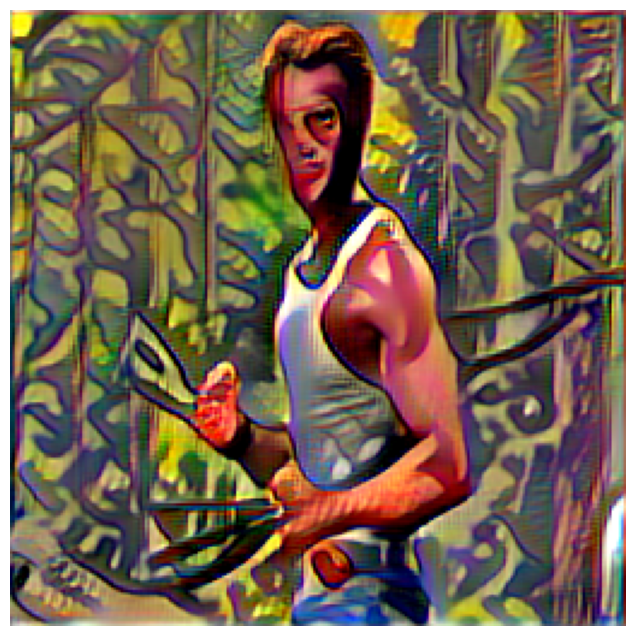

In [42]:
import torch
#10K pics in training set

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(tensor.device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(tensor.device)
    return tensor * std + mean

out_img = denormalize(output).clamp(0,1)

import torchvision.utils as vutils
vutils.save_image(out_img, "stylized_result.jpg")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(out_img.squeeze(0).permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()


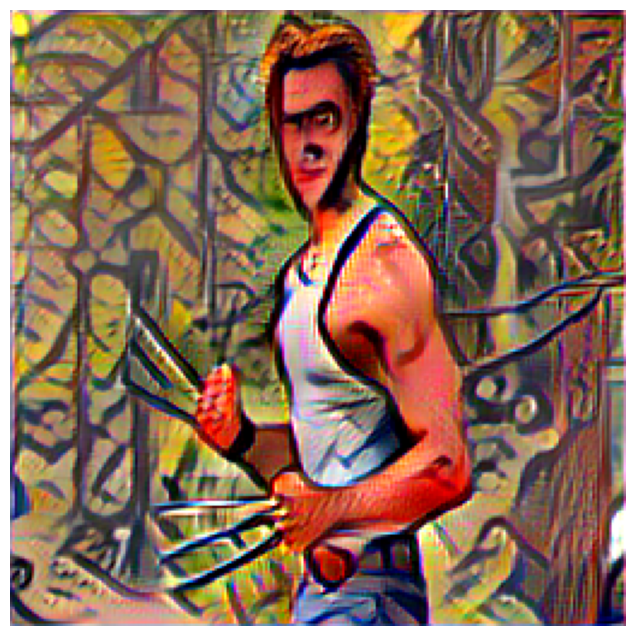

In [25]:
import torch
#80K pics in training set

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(tensor.device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(tensor.device)
    return tensor * std + mean

out_img = denormalize(output).clamp(0,1)

import torchvision.utils as vutils
vutils.save_image(out_img, "stylized_result.jpg")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(out_img.squeeze(0).permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()


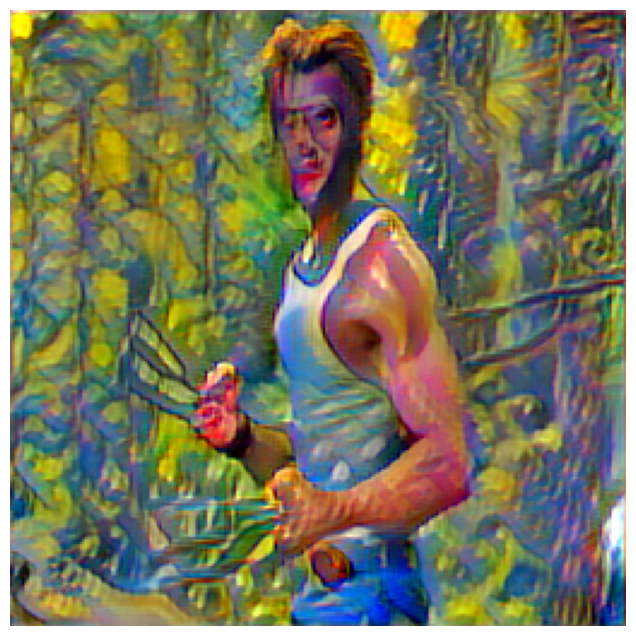

In [45]:
import torch
#10K pics in training set

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(tensor.device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(tensor.device)
    return tensor * std + mean

out_img = denormalize(output).clamp(0,1)

import torchvision.utils as vutils
vutils.save_image(out_img, "stylized_result.jpg")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(out_img.squeeze(0).permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()
